In [31]:
# =================================
# LIBRARIES
# =================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# =================================
# LOAD & PREVIEW DATA
# =================================

# Create a directory for the data
!mkdir -p data

# Download the dataset from data.transportation.gov
!wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset
data_path = "data/raw_data.csv"
df_full = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df_full.head()

#print(df.columns)


--2025-03-19 19:14:41--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.transportation.gov (data.transportation.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [             <=>    ]  91.30M  4.06MB/s    in 25s     

2025-03-19 19:15:06 (3.61 MB/s) - ‘data/raw_data.csv’ saved [95738829]



,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,TOS,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Injuries,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Trespasser Inuries (Subtotal),Trespasser Serious Injuries (Subtotal),Total Serious Injuries,Person List
0,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,Bus was parked in <REDACTED> <REDACTED> and an...,...,0,0,0,0,0,0,0,0,0,NaN
1,40035,Central Florida Regional Transportation Authority,65863,Bus,Demand Response,DR,DO,False,2024,Another vehicle made other front contact with ...,...,1,0,0,0,0,0,0,0,0,I Operator Inside Adult (19 to 60) F ; I ...
2,50027,Metro Transit,57628,Rail,Light Rail,LR,DO,True,2024,Officers responded to a shooting . Suspect was...,...,0,0,0,0,0,0,0,0,0,F Passenger Adult (19 to 60) M
3,90026,San Diego Metropolitan Transit System,78661,Rail,Light Rail,LR,DO,True,2024,San Diego Police took a female into custody af...,...,0,0,0,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M Y
4,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,operator was driving down <REDACTED> <REDACTED...,...,1,0,0,0,0,0,0,0,0,I Occ Other Veh Adult (19 to 60) M


In [3]:

# =================================
# CLEANING & FEATURE ENGINEERING
# =================================
#df['Year'] = df['Event Date'].dt.year
#df['Month'] = df['Event Date'].dt.month
#df['Weekday'] = df['Event Date'].dt.weekday

# Selected Columns
# Define the list of columns to keep
columns_to_keep = [
    'NTD ID',
    'Primary UZA UACE Code',
    'Rail/Bus/Ferry',
    'Mode Name',
    'Mode',
    'TOS',
    'Fixed Route Flag',
    'Year',
    'Event Date',
    'Event Time',
    'Event Type',
    'Event Type Group',
    'Collision With',
    'Property Damage',
    'Total Injuries',
    'Total Fatalities',
    'Towed (Y/N)',
    'Number of Transit Vehicles Involved',
    'Number of Non-Transit Vehicles Involved',
    'Number of Cars on Involved Transit Vehicles',
    'Non-Transit Vehicle Type List',
    'Location Type',
    'Latitude',
    'Longitude',
    'Weather',
    'Lighting',
    'Road Configuration',
    'Path Condition',
    'Right of Way Condition',
    'Intersection Control Device',
    'Transit Vehicle Action',
    'Other Transit Vehicle Action Description',
    'Non-Transit Vehicle Action List',
    'Transit (Y/N)',
    'Fuel Type',
    'Vehicle Speed',
    'Transit Vehicle Type',
    'Non-Transit Vehicle Type',
    'Transit Vehicle Manufacturer',
    'Total Serious Injuries'
]

df = df_full[columns_to_keep]
df.columns = df.columns.str.replace(' ', '')

In [4]:
eventtype = 'Non-Rail Collision'

df = df.query('EventType == @eventtype')

In [5]:
# count the number of missing values in each column
missing_values = df.isnull().sum()

# drop columns with more than 10% missing values
columns_to_drop = missing_values[missing_values > 0.1 * df.shape[0]].index
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()

# drop duplicates
df = df.drop_duplicates()

# save the cleaned data, save to data folder as data_cleaned.csv
df.to_csv('data/cleaned_data.csv', index=False)

# print the number of rows and columns in the cleaned data
print(df.shape)

# print the number of missing values in the cleaned data
print(df.isnull().sum())

# print the number of duplicates in the cleaned data
print(df.duplicated().sum())

# print the first few rows of the cleaned data
print(df.head())

(62153, 34)
NTDID                                    0
PrimaryUZAUACECode                       0
Rail/Bus/Ferry                           0
ModeName                                 0
Mode                                     0
TOS                                      0
FixedRouteFlag                           0
Year                                     0
EventDate                                0
EventTime                                0
EventType                                0
EventTypeGroup                           0
CollisionWith                            0
PropertyDamage                           0
TotalInjuries                            0
TotalFatalities                          0
Towed(Y/N)                               0
NumberofTransitVehiclesInvolved          0
NumberofNon-TransitVehiclesInvolved      0
NumberofCarsonInvolvedTransitVehicles    0
LocationType                             0
Weather                                  0
Lighting                                 0

In [6]:
# =================================
# DEFINE TARGET VARIABLE
# =================================
df['Is_Severe'] = (
    (df['TotalFatalities'] > 0) |
    (df['TotalSeriousInjuries'] >0)
).astype(int)

X = df.drop(columns=['Is_Severe'])
y = df['Is_Severe']

#f['Is_Severe'].value_counts()


In [7]:
# =================================
# PREPROCESSING PIPELINE
# =================================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [33]:
baseline_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier1= GradientBoostingClassifier()
classifier2= BaggingClassifier()

In [34]:
Pipeline_Base = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', baseline_classifier)
])


Pipeline_1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier1)
])

Pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier2)
])

#BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#KNeighborsClassifier()


In [16]:
# =================================
# MODEL TRAINING
# =================================
#pipeline = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
#])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
Pipeline_Base.fit(X_train, y_train)
y_pred = Pipeline_Base.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12251
           1       1.00      0.66      0.80       180

    accuracy                           1.00     12431
   macro avg       1.00      0.83      0.90     12431
weighted avg       1.00      1.00      0.99     12431

Confusion Matrix:
[[12251     0]
 [   61   119]]
ROC-AUC Score: 0.8305555555555555


In [35]:
Pipeline_1.fit(X_train, y_train)
y_pred = Pipeline_1.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12251
           1       1.00      1.00      1.00       180

    accuracy                           1.00     12431
   macro avg       1.00      1.00      1.00     12431
weighted avg       1.00      1.00      1.00     12431

Confusion Matrix:
[[12251     0]
 [    0   180]]
ROC-AUC Score: 1.0


In [36]:
Pipeline_2.fit(X_train, y_train)
y_pred = Pipeline_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12251
           1       1.00      1.00      1.00       180

    accuracy                           1.00     12431
   macro avg       1.00      1.00      1.00     12431
weighted avg       1.00      1.00      1.00     12431

Confusion Matrix:
[[12251     0]
 [    0   180]]
ROC-AUC Score: 1.0



Top 10 Predictive Features:
                    Feature  Importance
5           TotalFatalities    0.384767
4             TotalInjuries    0.045823
3            PropertyDamage    0.027381
0                     NTDID    0.017308
1        PrimaryUZAUACECode    0.015606
9              VehicleSpeed    0.014948
11961  CollisionWith_Person    0.013816
2                      Year    0.011338
11967          Towed(Y/N)_Y    0.010137
11966          Towed(Y/N)_N    0.007752


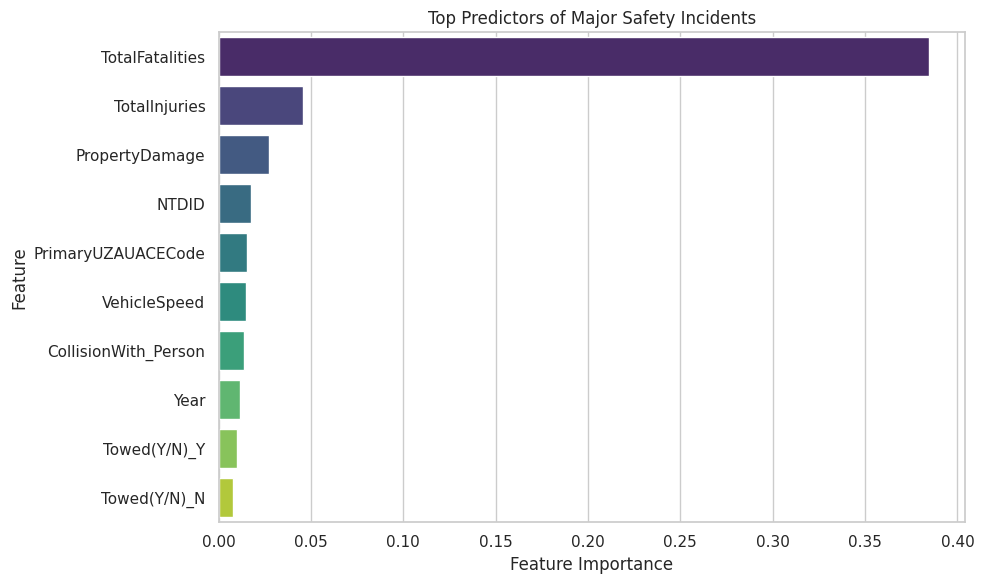

In [22]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
ohe = Pipeline_Base.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



Top 10 Predictive Features:
                                                 Feature    Importance
5                                        TotalFatalities  1.000000e+00
2                                                   Year  5.776569e-15
12283  TransitVehicleType_Transit demand response veh...  2.026227e-15
9                                           VehicleSpeed  1.458348e-15
3                                         PropertyDamage  6.094146e-16
0                                                  NTDID  3.182107e-16
8338                                EventTime_5:00:09 PM  0.000000e+00
8340                                EventTime_5:00:12 PM  0.000000e+00
8341                                EventTime_5:00:13 PM  0.000000e+00
8342                                EventTime_5:00:20 PM  0.000000e+00


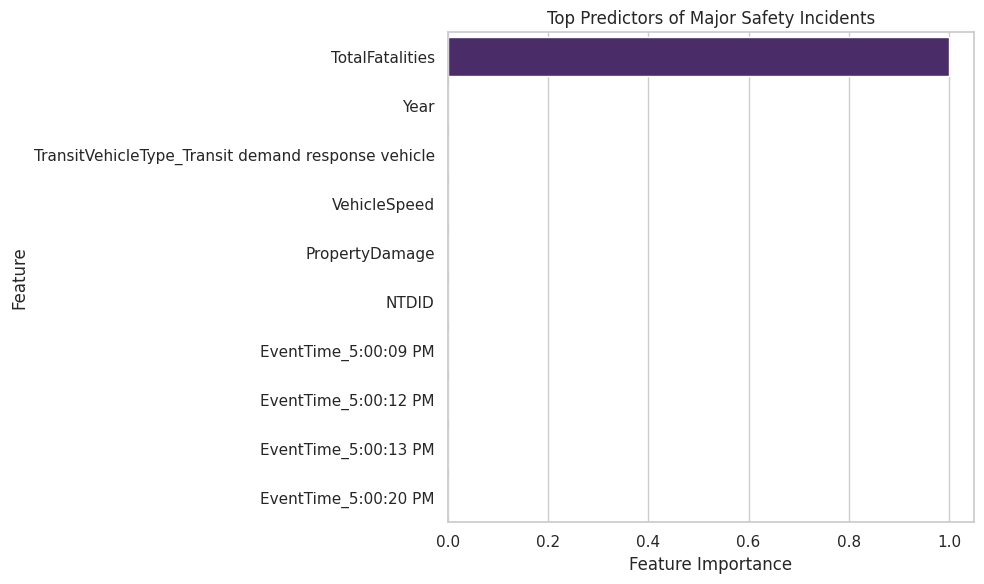

In [37]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_1.named_steps['classifier']

# Get feature names
ohe = Pipeline_1.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [38]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_2.named_steps['classifier']

# Get feature names
ohe = Pipeline_2.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'